This notebook demonstrates how to use learned optimizers in the VeLO family on 

1) a simple image recognition task

and

2) resnets


This notebook installs dependencies in the first cell, and is compatible with any runtime, though it works best with TPU and GPU runtimes.


If you would like to see a more pedagogical introduction to our learned optimization library, please take a look at our [introductory notebooks](https://github.com/google/learned_optimization#learned_optimization-tutorial-sequence).


* add baseline to resnet (param for opt)

In [ ]:
#@title Accelerator Setup, Library Instillation, and Imports (Run this cell first!)

Accelerator_Type = 'GPU' #@param ["GPU", "TPU", "CPU"]

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


# install lopt
!pip install git+https://github.com/google/learned_optimization.git

import jax
if Accelerator_Type == 'TPU':
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()

from learned_optimization.tasks.fixed import image_mlp
from learned_optimization.research.general_lopt import prefab
from learned_optimization import eval_training

from matplotlib import pylab as plt
from learned_optimization import notebook_utils as nu
import numpy as onp


from learned_optimization.baselines import utils
import os
# use the precomputed baselines folder from gcp for loading baseline training curves
os.environ["LOPT_BASELINE_ARCHIVES_DIR"] = "gs://gresearch/learned_optimization/opt_archives/"


# Using Optax style optimizers

In [ ]:
import optax
# defining an optimizer that targets 1000 training steps
NUM_STEPS = 1000
opt = prefab.optax_lopt(NUM_STEPS)

In [ ]:
#@title defining and executing a simple training loop


# Learned_optimization contains a handful of predefined tasks.  These tasks
# wrap the model initialization and dataset definitions in one convenient
# object.  Here, we initialize a simple MLP for the fashionmnist dataset.
task = image_mlp.ImageMLP_FashionMnist8_Relu32()

# We initialize the underlying MLP and collect its state using its init
# function.  Under the hood, this is really just initializing a haiku model
# as seen here (https://github.com/google/learned_optimization/blob/main/learned_optimization/tasks/fixed/image_mlp.py#L58).
key = jax.random.PRNGKey(0)
params = task.init(key)

# finally, we initialize the optimizer with the model state:
opt_state = opt.init(params)



In [ ]:
# For a training loop, all we need is an update function.  This update function
# takes existing optimizer state, model params, training data, and randomness
# as args, and returns new optimizer state, new model params, and the loss.

@jax.jit
def update(opt_state, params, data, key):
  """Simple training update function.
  Args:
    opt_state: Optimizer state
    params: Model parameter weights
    data: Training data
    key: Jax randomness
  
  Returns:
    A tuple of updated optimizer state, model state, and the current loss."""
  l, g = jax.value_and_grad(task.loss)(params, key, data)
  updates, opt_state = opt.update(g, opt_state, params=params, extra_args={"loss": l})
  params = optax.apply_updates(params, updates)
  return opt_state, params, l


# a simple training loop

losses = []
for i in range(NUM_STEPS):
  batch = next(task.datasets.train)
  key1, key = jax.random.split(key)
  opt_state, params, l = update(opt_state, params, batch, key1)
  losses.append(l)

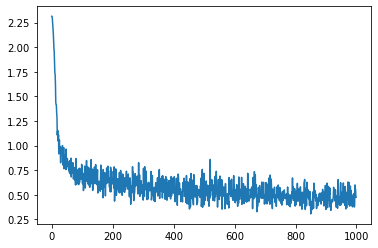

In [ ]:
#@title visualizing FashionMnist Loss

# here we visualize the loss during training
plt.plot(losses)

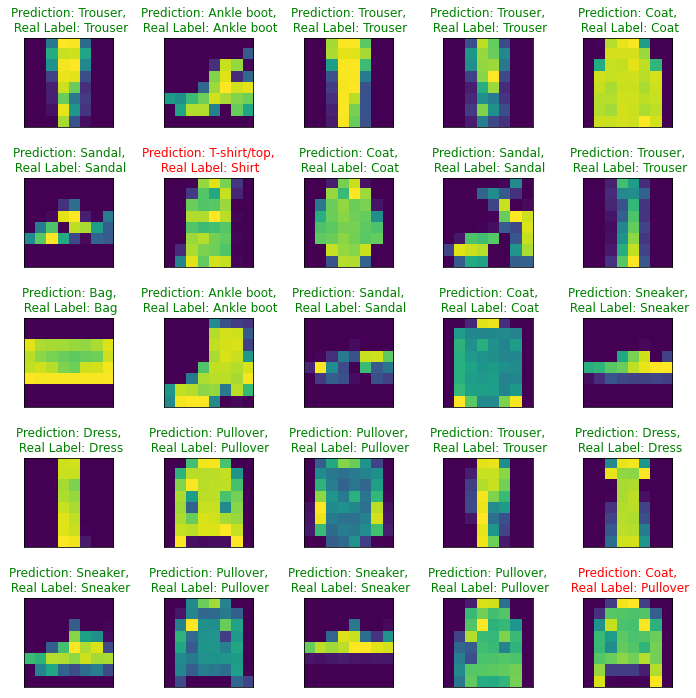

In [ ]:
# We can also inspect and visualize some model predictions:
predictions = task._mod.apply(params, key, batch["image"])
labels = batch["label"]

fashion_mnist_label_to_name = { 0:	"T-shirt/top",
                                1:	"Trouser",
                                2:	"Pullover",
                                3:	"Dress",
                                4:	"Coat",
                                5:	"Sandal",
                                6:	"Shirt",
                                7:	"Sneaker",
                                8:	"Bag",
                                9:	"Ankle boot"}

import matplotlib.pyplot as plt


fig, axs = plt.subplots(5, 5)
fig.set_size_inches(10, 10)
for i in range(5):
  for j in range(5):
    pred = fashion_mnist_label_to_name[int(jax.numpy.argmax(predictions,axis=1)[5*i+j])]
    real = fashion_mnist_label_to_name[labels[5*i+j]]
    color = 'g' if pred==real else 'r'
    axs[i, j].imshow(batch["image"][5*i+j])
    axs[i, j].set_title(f'Prediction: {pred},\n Real Label: {real}', color=color)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])

fig.tight_layout(pad=2.0)



# Training Resnets with VeLO


This example is meant to illustrate how to slot VeLO into a more mature training pipeline.  Below, we largely crib from the resnet training example in [jaxopt](https://jaxopt.github.io/stable/auto_examples/deep_learning/flax_resnet.html).


The main intervention necessary for VeLO to function is to make sure that it is provided the training loss as a feature.  Below, we perform the minimal necessary modifications to `jaxopt`'s `solver` interface to facilitate this plumbing.

In [ ]:
#@title imports, configuration, and model classes


!pip install jaxopt


from absl import app
from datetime import datetime

from functools import partial
from typing import Any, Callable, Sequence, Tuple

from flax import linen as nn

import jax
import jax.numpy as jnp

from jaxopt import loss
from jaxopt import OptaxSolver
from jaxopt import tree_util

import optax

import tensorflow_datasets as tfds
import tensorflow as tf


dataset_names = [
    "mnist", "kmnist", "emnist", "fashion_mnist", "cifar10", "cifar100"
]


L2REG = 1e-4
LEARNING_RATE = .2
EPOCHS = 10
MOMENTUM = .9
DATASET = 'cifar100' #@param [ "mnist", "kmnist", "emnist", "fashion_mnist", "cifar10", "cifar100"]
MODEL = 'resnet18' #@param ["resnet1", "resnet18", "resnet34"]
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 1024


def load_dataset(split, *, is_training, batch_size):
  version = 3
  ds, ds_info = tfds.load(
      f"{DATASET}:{version}.*.*",
      as_supervised=True,  # remove useless keys
      split=split,
      with_info=True)
  ds = ds.cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds)), ds_info


class ResNetBlock(nn.Module):
  """ResNet block."""
  filters: int
  conv: Any
  norm: Any
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x,):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros)(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters, (1, 1),
                           self.strides, name='conv_proj')(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class ResNet(nn.Module):
  """ResNetV1."""
  stage_sizes: Sequence[int]
  block_cls: Any
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(nn.Conv, use_bias=False, dtype=self.dtype)
    norm = partial(nn.BatchNorm,
                   use_running_average=not train,
                   momentum=0.9,
                   epsilon=1e-5,
                   dtype=self.dtype)

    x = conv(self.num_filters, (7, 7), (2, 2),
             padding=[(3, 3), (3, 3)],
             name='conv_init')(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(self.num_filters * 2 ** i,
                           strides=strides,
                           conv=conv,
                           norm=norm,
                           act=self.act)(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


ResNet1 = partial(ResNet, stage_sizes=[1], block_cls=ResNetBlock)
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
ResNet34 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=ResNetBlock)




In [ ]:
#@title training loop definition (run this cell to launch training)
import functools
from typing import Any
from typing import Callable
from typing import NamedTuple
from typing import Optional

from dataclasses import dataclass

import jax
import jax.numpy as jnp

from jaxopt._src import base
from jaxopt._src import tree_util



class OptaxState(NamedTuple):
  """Named tuple containing state information."""
  iter_num: int
  value: float
  error: float
  internal_state: NamedTuple
  aux: Any

# we need to reimplement optax's OptaxSolver's lopt_update method to properly pass in the loss data that VeLO expects.
def lopt_update(self,
            params: Any,
            state: NamedTuple,
            *args,
            **kwargs) -> base.OptStep:
  """Performs one iteration of the optax solver.

  Args:
    params: pytree containing the parameters.
    state: named tuple containing the solver state.
    *args: additional positional arguments to be passed to ``fun``.
    **kwargs: additional keyword arguments to be passed to ``fun``.
  Returns:
    (params, state)
  """
  if self.pre_update:
    params, state = self.pre_update(params, state, *args, **kwargs)

  (value, aux), grad = self._value_and_grad_fun(params, *args, **kwargs)

  # note the only difference between this function and the baseline 
  # optax.OptaxSolver.lopt_update is that `extra_args` is now passed.
  # if you would like to use a different optimizer, you will likely need to
  # remove these extra_args.
  delta, opt_state = self.opt.update(grad, state.internal_state, params, extra_args={"loss": value})
  params = self._apply_updates(params, delta)

  # Computes optimality error before update to re-use grad evaluation.
  new_state = OptaxState(iter_num=state.iter_num + 1,
                          error=tree_util.tree_l2_norm(grad),
                          value=value,
                          aux=aux,
                          internal_state=opt_state)
  return base.OptStep(params=params, state=new_state)




def train():

  # Hide any GPUs from TensorFlow. Otherwise TF might reserve memory and make
  # it unavailable to JAX.
  # tf.config.experimental.set_visible_devices([], 'GPU')


  # typical data loading and iterator setup

  train_ds, ds_info = load_dataset("train", is_training=True,
                                    batch_size=TRAIN_BATCH_SIZE)
  test_ds, _ = load_dataset("test", is_training=False,
                            batch_size=TEST_BATCH_SIZE)
  input_shape = (1,) + ds_info.features["image"].shape
  num_classes = ds_info.features["label"].num_classes
  iter_per_epoch_train = ds_info.splits['train'].num_examples // TRAIN_BATCH_SIZE
  iter_per_epoch_test = ds_info.splits['test'].num_examples // TEST_BATCH_SIZE

  # Set up model.
  if MODEL == "resnet1":
    net = ResNet1(num_classes=num_classes)
  elif MODEL == "resnet18":
    net = ResNet18(num_classes=num_classes)
  elif MODEL == "resnet34":
    net = ResNet34(num_classes=num_classes)
  else:
    raise ValueError("Unknown model.")

  def predict(params, inputs, aux, train=False):
    x = inputs.astype(jnp.float32) / 255.
    all_params = {"params": params, "batch_stats": aux}
    if train:
      # Returns logits and net_state (which contains the key "batch_stats").
      return net.apply(all_params, x, train=True, mutable=["batch_stats"])
    else:
      # Returns logits only.
      return net.apply(all_params, x, train=False)

  logistic_loss = jax.vmap(loss.multiclass_logistic_loss)

  def loss_from_logits(params, l2reg, logits, labels):
    mean_loss = jnp.mean(logistic_loss(labels, logits))
    sqnorm = tree_util.tree_l2_norm(params, squared=True)
    return mean_loss + 0.5 * l2reg * sqnorm

  def accuracy_and_loss(params, l2reg, data, aux):
    inputs, labels = data
    logits = predict(params, inputs, aux)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    loss = loss_from_logits(params, l2reg, logits, labels)
    return accuracy, loss

  def loss_fun(params, l2reg, data, aux):
    inputs, labels = data
    logits, net_state = predict(params, inputs, aux, train=True)
    loss = loss_from_logits(params, l2reg, logits, labels)
    # batch_stats will be stored in state.aux
    return loss, net_state["batch_stats"]

  # The default optimizer used by jaxopt is commented out here
  # opt = optax.sgd(learning_rate=LEARNING_RATE,
  #                 momentum=MOMENTUM,
  #                 nesterov=True)
  
  NUM_STEPS = EPOCHS * iter_per_epoch_train
  opt = prefab.optax_lopt(NUM_STEPS)
  
  # We need has_aux=True because loss_fun returns batch_stats.
  solver = OptaxSolver(opt=opt, 
                       fun=jax.value_and_grad(loss_fun, has_aux=True), 
                       maxiter=EPOCHS * iter_per_epoch_train, 
                       has_aux=True, 
                       value_and_grad=True)

  # Initialize parameters.
  rng = jax.random.PRNGKey(0)
  init_vars = net.init(rng, jnp.zeros(input_shape), train=True)
  params = init_vars["params"]
  batch_stats = init_vars["batch_stats"]
  start = datetime.now().replace(microsecond=0)

  # Run training loop.
  state = solver.init_state(params, L2REG, next(test_ds), batch_stats)
  jitted_update = jax.jit(functools.partial(lopt_update, self=solver))
  print(f'Iterations: {solver.maxiter}')

  for _ in range(solver.maxiter):
    train_minibatch = next(train_ds)

    if state.iter_num % iter_per_epoch_train == iter_per_epoch_train - 1:
      # Once per epoch evaluate the model on the train and test sets.
      test_acc, test_loss = 0., 0.
      # make a pass over test set to compute test accuracy
      for _ in range(iter_per_epoch_test):
          tmp = accuracy_and_loss(params, L2REG, next(test_ds), batch_stats)
          test_acc += tmp[0] / iter_per_epoch_test
          test_loss += tmp[1] / iter_per_epoch_test

      train_acc, train_loss = 0., 0.
      # make a pass over train set to compute train accuracy
      for _ in range(iter_per_epoch_train):
          tmp = accuracy_and_loss(params, L2REG, next(train_ds), batch_stats)
          train_acc += tmp[0] / iter_per_epoch_train
          train_loss += tmp[1] / iter_per_epoch_train

      train_acc = jax.device_get(train_acc)
      train_loss = jax.device_get(train_loss)
      test_acc = jax.device_get(test_acc)
      test_loss = jax.device_get(test_loss)
      # time elapsed without microseconds
      time_elapsed = (datetime.now().replace(microsecond=0) - start)

      print(f"[Epoch {(state.iter_num+1) // (iter_per_epoch_train+1)}/{EPOCHS}] "
            f"Train acc: {train_acc:.3f}, train loss: {train_loss:.3f}. "
            f"Test acc: {test_acc:.3f}, test loss: {test_loss:.3f}. "
            f"Time elapsed: {time_elapsed}")

    params, state = jitted_update(params=params,
                                  state=state,
                                  l2reg=L2REG,
                                  data=train_minibatch,
                                  aux=batch_stats)
    batch_stats = state.aux

train()

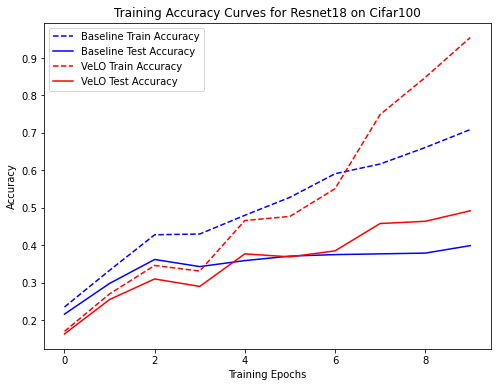

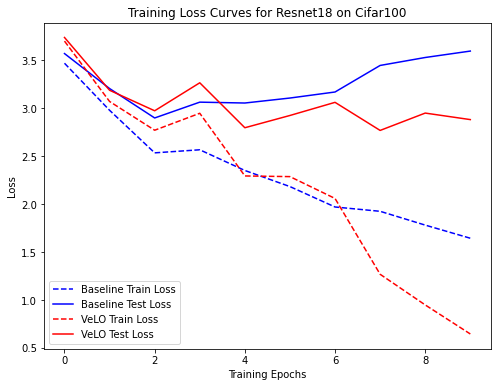

In [2]:
#@title Comparing a baseline optimizer vs. VeLO on resnet18 cifar100.
baseline_train_acc = [0.235,
0.333,
0.428,
0.430,
0.480,
0.528,
0.591,
0.617,
0.661,
0.709,]

baseline_test_acc = [0.216,
0.298,
0.362,
0.343,
0.359,
0.371,
0.375,
0.377,
0.379,
0.399,]


velo_train_acc = [0.170,
0.270,
0.346,
0.331,
0.466,
0.477,
0.551,
0.749,
0.848,
0.955,]

velo_test_acc = [0.163,
0.255,
0.310,
0.290,
0.377,
0.369,
0.385,
0.458,
0.464,
0.492,]


from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(range(10), baseline_train_acc, label="Baseline Train Accuracy", c='b',  linestyle='dashed')
plt.plot(range(10), baseline_test_acc, label = "Baseline Test Accuracy", c='b')
plt.plot(range(10), velo_train_acc, label= "VeLO Train Accuracy", c='r', linestyle='dashed')
plt.plot(range(10), velo_test_acc, label="VeLO Test Accuracy", c='r')
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curves for Resnet18 on Cifar100")
plt.legend()
plt.show()






#@title Comparing a baseline optimizer vs. VeLO on resnet18 cifar100.
baseline_train_loss = [3.470,
2.979,
2.535,
2.567,
2.351,
2.183,
1.970,
1.925,
1.781,
1.644,]

baseline_test_loss = [3.571,
3.206,
2.899,
3.064,
3.055,
3.107,
3.170,
3.447,
3.530,
3.597,]


velo_train_loss = [3.701,
3.071,
2.771,
2.948,
2.294,
2.287,
2.059,
1.268,
0.948,
0.645,]

velo_test_loss = [3.739,
3.188,
2.974,
3.266,
2.797,
2.925,
3.062,
2.769,
2.950,
2.882]


from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(range(10), baseline_train_loss, label="Baseline Train Loss", c='b',  linestyle='dashed')
plt.plot(range(10), baseline_test_loss, label = "Baseline Test Loss", c='b')
plt.plot(range(10), velo_train_loss, label= "VeLO Train Loss", c='r', linestyle='dashed')
plt.plot(range(10), velo_test_loss, label="VeLO Test Loss", c='r')
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curves for Resnet18 on Cifar100 ")
plt.legend()
plt.show()